In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.special import softmax
from numpy.random import multivariate_normal as mvn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Graphing Parameters
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

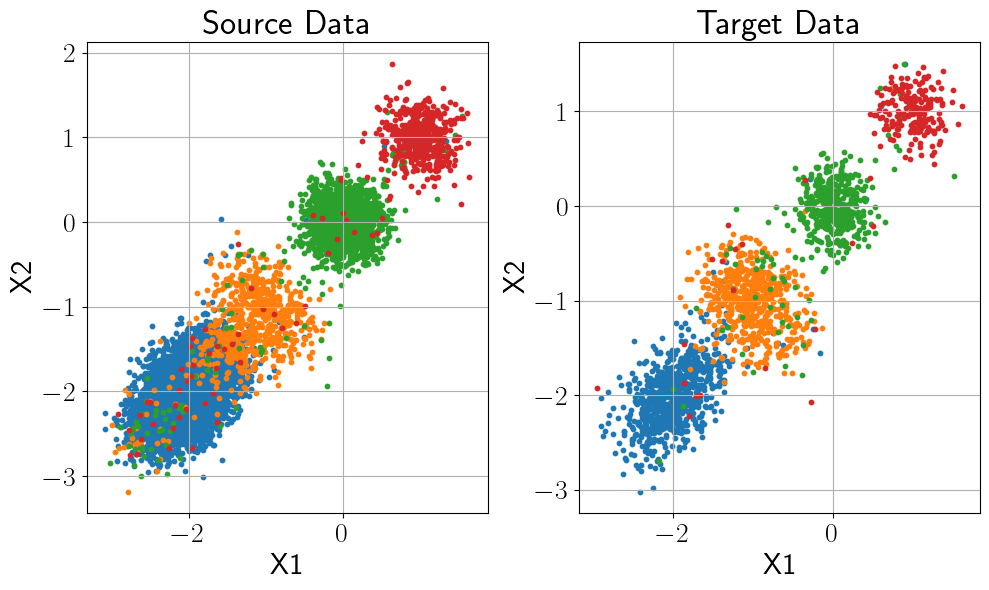

In [2]:

# 1. Define mixture components for bivariate Gaussians
mixture_weights_source = np.array([0.7, 0.05, 0.2, 0.05])  # mixture weights sum to 1
mixture_weights_target = np.array([0.4, 0.3, 0.2, 0.1])  # mixture weights sum to 1

means = [np.array([-2, -2]), np.array([-1, -1]), np.array([0, 0]), np.array([1, 1])]
covs = [np.array([[.1, 0.05], [0.05, .1]]),
        np.array([[.1, -0.03], [-0.03, .1]]),
        np.array([[0.05, 0], [0, 0.05]]),
        np.array([[0.05, 0], [0, 0.05]])]

# 2. Define f_i(x) functions for class probabilities
def class_logits(x):
    """Returns raw scores (logits) for each of 4 classes given input x (2D)."""
    # Linear and nonlinear features
    x1, x2 = x[0], x[1]
    return np.array([
        np.exp(-(x1 + 2)**2 - (x2 + 2)**2)/0.15,
        np.exp(-(x1 + 1)**2 - (x2 + 1)**2)/0.2,
        np.exp(-(x1 - 0)**2 - (x2 - 0)**2)/0.15,
        np.exp(-(x1 - 1)**2 - (x2 - 1)**2)/0.2,
    ])

# 3. Sampling procedure
def sample_data(n_samples, mixture_weights):
    X = []
    y = []
    for _ in range(n_samples):
        # Choose Gaussian component
        k = np.random.choice(len(mixture_weights), p=mixture_weights)
        x = mvn(mean=means[k], cov=covs[k])
        logits = class_logits(x)
        probs = softmax(logits)  # Convert to probabilities
        label = np.random.choice(4, p=probs)
        X.append(x)
        y.append(label)
    return np.array(X), np.array(y)

# 4. Visualize sample
X_s, y_s = sample_data(10000, mixture_weights_source)
X_t, y_t = sample_data(2000, mixture_weights_target)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for i in range(4):
    axs[0].scatter(X_s[y_s == i, 0], X_s[y_s == i, 1], s=10, label=f'Class {i}')
axs[0].set_title("Source Data")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")
axs[0].grid(True)

for i in range(4):
    axs[1].scatter(X_t[y_t == i, 0], X_t[y_t == i, 1], s=10, label=f'Class {i}')
axs[1].set_title("Target Data")
axs[1].set_xlabel("X1")
axs[1].set_ylabel("X2")
axs[1].grid(True)

plt.tight_layout()
plt.show()


/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy: 0.932
Confusion matrix:
 [[1350    1    3    1]
 [  75   64   25    0]
 [   8    3  362    7]
 [   6    1    5   89]]


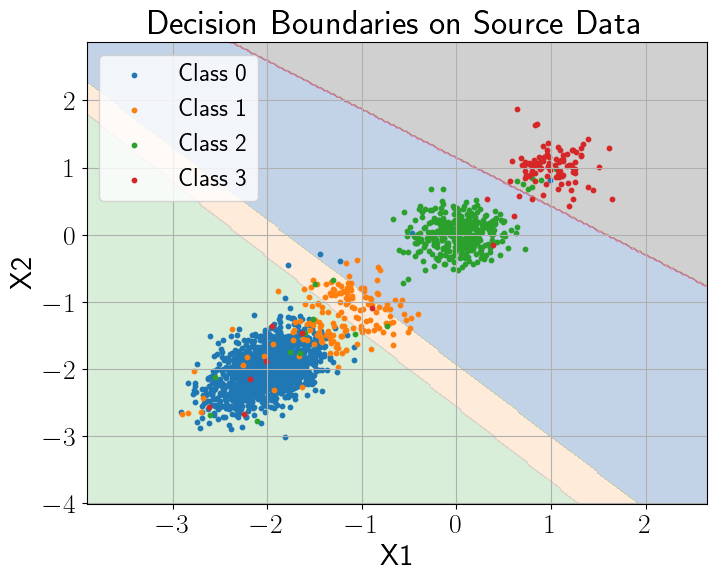

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# ---------- Step 3: Fit logistic regression ----------
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

# ---------- Step 4: Evaluate ----------
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Test accuracy: {acc:.3f}")
print("Confusion matrix:\n", cm)

# ---------- Step 5: Visualize decision boundaries ----------
def plot_decision_boundary(clf, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, probs, alpha=0.3, cmap='Accent')
    for i in range(4):
        plt.scatter(X[y == i, 0], X[y == i, 1], s=10, label=f'Class {i}')
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_decision_boundary(clf, X_test, y_test, title="Decision Boundaries on Source Data")

Test accuracy: 0.834
Confusion matrix:
 [[771  11   4   2]
 [ 85 276 185   1]
 [  8   7 426  10]
 [  7   4   9 194]]


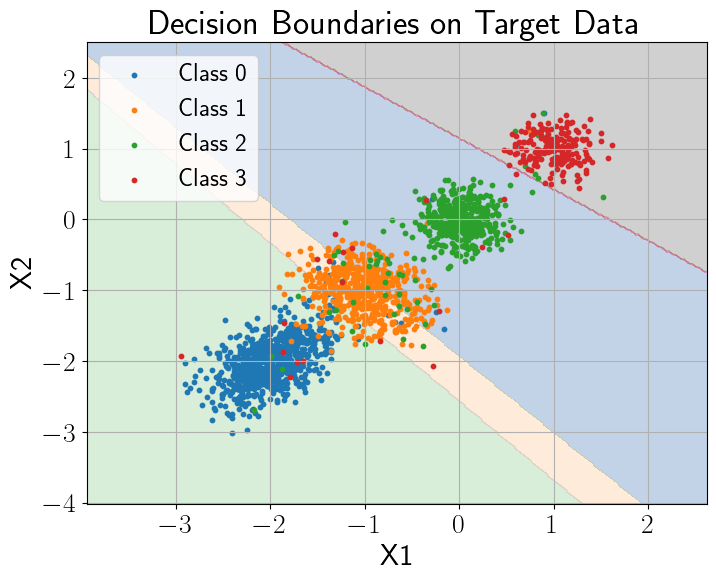

In [4]:
# ---------- Step 5: Evaluate on target data ----------
y_pred = clf.predict(X_t)
acc = accuracy_score(y_t, y_pred)
cm = confusion_matrix(y_t, y_pred)

print(f"Test accuracy: {acc:.3f}")
print("Confusion matrix:\n", cm)


# ---------- Step 6: Visualize decision boundaries ----------

plot_decision_boundary(clf, X_t, y_t, title="Decision Boundaries on Target Data")

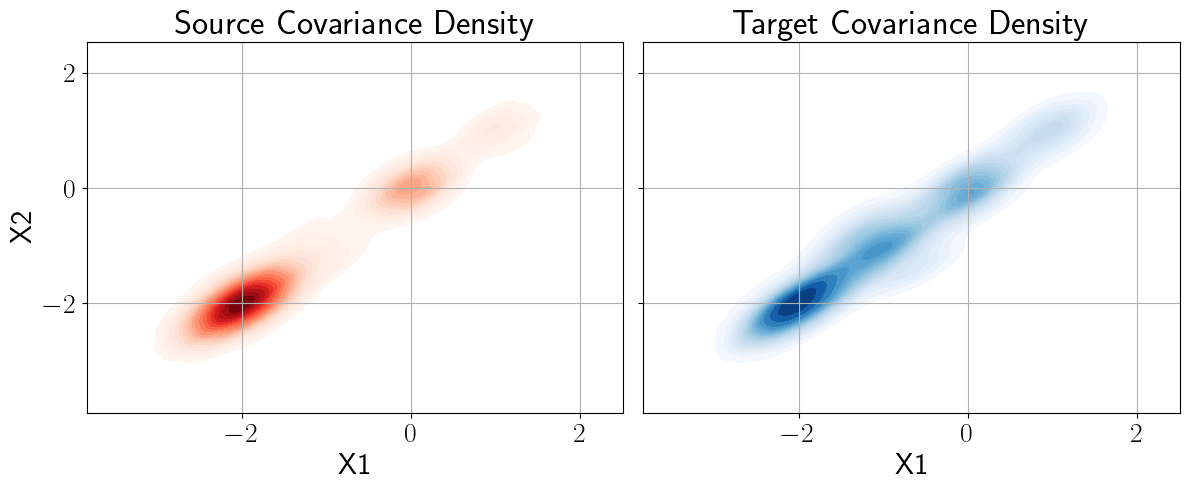

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Dataset 1
sns.kdeplot(x=X_s[:,0], y=X_s[:,1], cmap="Reds", fill=True, thresh=0.05, levels=20, ax=axs[0])
axs[0].set_title("Source Covariance Density")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")
axs[0].grid(True)

# Dataset 2
sns.kdeplot(x=X_t[:,0], y=X_t[:,1], cmap="Blues", fill=True, thresh=0.05, levels=20, ax=axs[1])
axs[1].set_title("Target Covariance Density")
axs[1].set_xlabel("X1")
axs[1].set_ylabel("X2")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
print(np.unique(clf.predict(X_cal), return_counts=True))
print(np.unique(y_cal, return_counts=True))

(array([0, 1, 2, 3]), array([1462,   49,  388,  101]))
(array([0, 1, 2, 3]), array([1378,  145,  368,  109]))


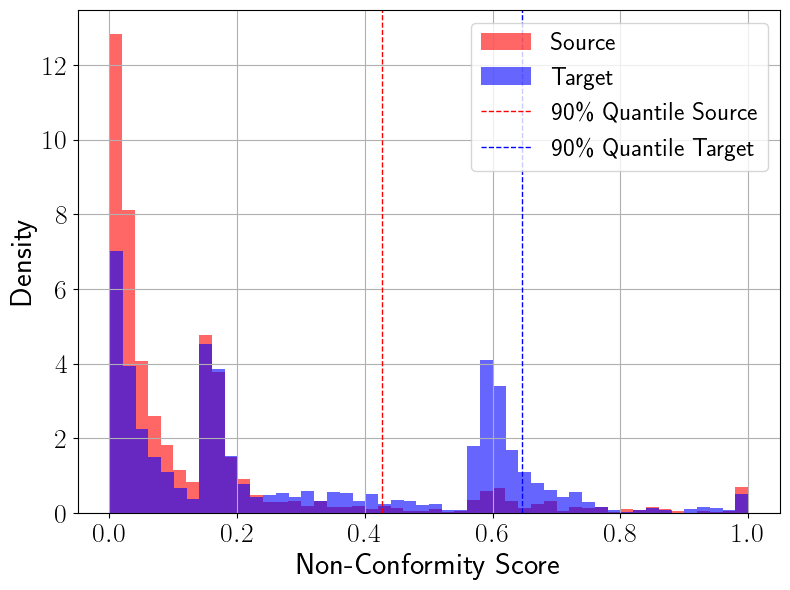

In [239]:
scores_cal_source = 1 - clf.predict_proba(X_cal)[np.arange(len(y_cal)), y_cal]
scores_target = 1 - clf.predict_proba(X_t)[np.arange(len(y_t)), y_t]

plt.figure(figsize=(8, 6))

plt.hist(scores_cal_source, bins=50, color='red', alpha=0.6, density=True, label='Source')
plt.hist(scores_target, bins=50, color='blue', alpha=0.6, density=True, label='Target')
plt.axvline(x=np.quantile(scores_cal_source, 0.90), color='red', linestyle='--', label='90\% Quantile Source')
plt.axvline(x=np.quantile(scores_target, 0.90), color='blue', linestyle='--', label='90\% Quantile Target')

plt.xlabel("Non-Conformity Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy before OT fitting: 0.9375
Accuracy after OT fitting: 0.948


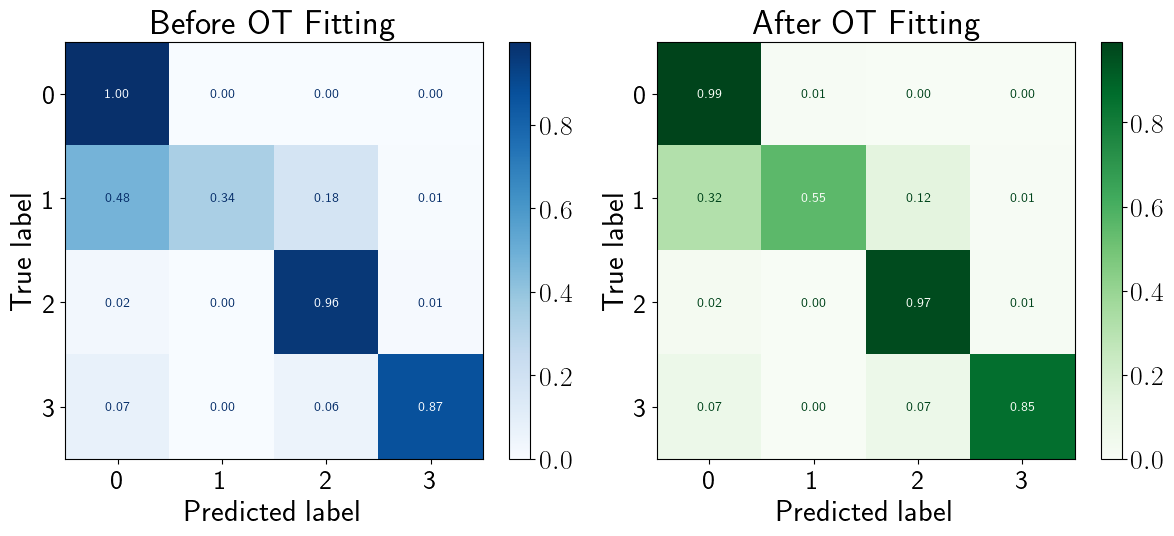

In [ ]:
import ot 
from sklearn.metrics import ConfusionMatrixDisplay

cost_source = 1 - clf.predict_proba(X_cal)
a_source = np.ones(len(cost_source))/len(cost_source)
b_source = mixture_weights_source

gamma_source = ot.sinkhorn(a_source, b_source, cost_source, reg=0.1)
gamma_acc_source = np.mean(np.argmax(gamma_source, axis=1) == y_cal)

print(f"Accuracy before OT fitting: {np.mean(clf.predict(X_cal) == y_cal)}")
print(f"Accuracy after OT fitting: {np.mean(np.argmax(gamma_source, axis=1) == y_cal)}")

y_pred_before_ot = clf.predict(X_cal)
y_pred_after_ot = np.argmax(gamma_source, axis=1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Model 1
ConfusionMatrixDisplay.from_predictions(
    y_cal, y_pred_before_ot, ax=axes[0], cmap='Blues',
    normalize='true', values_format=".2f"
)

axes[0].set_title("Before OT Fitting")

# Model 2
ConfusionMatrixDisplay.from_predictions(
    y_cal, y_pred_after_ot, ax=axes[1], cmap='Greens',
    normalize='true', values_format=".2f"
)
axes[1].set_title("After OT Fitting")

plt.tight_layout()
plt.show()

Accuracy before OT fitting: 0.8335
Accuracy after OT fitting: 0.9415


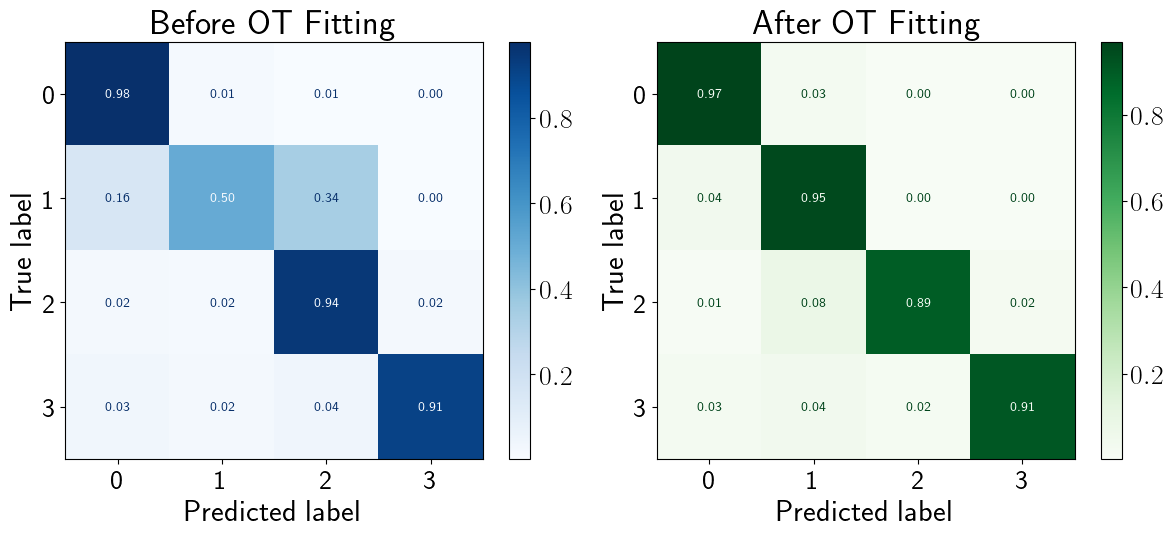

In [29]:
import ot 
from sklearn.metrics import ConfusionMatrixDisplay

cost_target = 1 - clf.predict_proba(X_t)
a_target = np.ones(len(cost_target))/len(cost_target)
b_target = mixture_weights_target

gamma_target = ot.sinkhorn(a_target, b_target, cost_target, reg=0.1)
gamma_acc_target = np.mean(np.argmax(gamma_target, axis=1) == y_t)

print(f"Accuracy before OT fitting: {np.mean(clf.predict(X_t) == y_t)}")
print(f"Accuracy after OT fitting: {np.mean(np.argmax(gamma_target, axis=1) == y_t)}")

y_pred_before_ot = clf.predict(X_t)
y_pred_after_ot = np.argmax(gamma_target, axis=1)
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Model 1
ConfusionMatrixDisplay.from_predictions(
    y_t, y_pred_before_ot, ax=axes[0], cmap='Blues',
    normalize='true', values_format=".2f"
)

axes[0].set_title("Before OT Fitting")

# Model 2
ConfusionMatrixDisplay.from_predictions(
    y_t, y_pred_after_ot, ax=axes[1], cmap='Greens',
    normalize='true', values_format=".2f"
)
axes[1].set_title("After OT Fitting")

plt.tight_layout()
plt.show()

In [ ]:
import ot 

cost_source = 1 - clf.predict_proba(X_cal)
cost_target = 1 - clf.predict_proba(X_t)

a_source = np.ones(len(cost_source))/len(cost_source)
b_source = mixture_weights_source

a_target = np.ones(len(cost_target))/len(cost_target)
b_target = mixture_weights_target

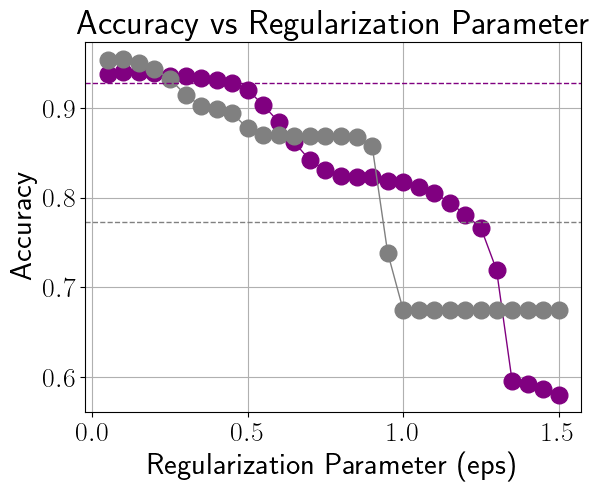

In [220]:
gamma_acc_eps_source = []
gamma_acc_eps_target = []

for eps in 0.05*np.arange(1,31):
    gamma_source = ot.sinkhorn(a_source, b_source, cost_source, reg=eps)
    gamma_target = ot.sinkhorn(a_target, b_target, cost_target, reg=eps)

    gamma_acc_source = np.sum(np.argmax(gamma_source, axis=1) == y_cal)/len(y_cal)
    gamma_acc_target = np.sum(np.argmax(gamma_target, axis=1) == y_t)/len(y_t)
    gamma_acc_eps_target.append(gamma_acc_source)
    gamma_acc_eps_source.append(gamma_acc_target)

plt.plot(0.05*np.arange(1,31), gamma_acc_eps_source, marker='o', label='Source Domain', color='purple')
plt.plot(0.05*np.arange(1,31), gamma_acc_eps_target, marker='o', label='Target Domain', color='grey')
plt.axhline(y = np.sum(np.argmax(clf.predict_proba(X_cal), axis=1) == y_cal)/len(y_cal), linestyle='--', color='purple')
plt.axhline(y = np.sum(np.argmax(clf.predict_proba(X_t), axis=1) == y_t)/len(y_t), linestyle='--', color='grey')

plt.xlabel("Regularization Parameter (eps)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Regularization Parameter")
plt.grid(True)
plt.show()

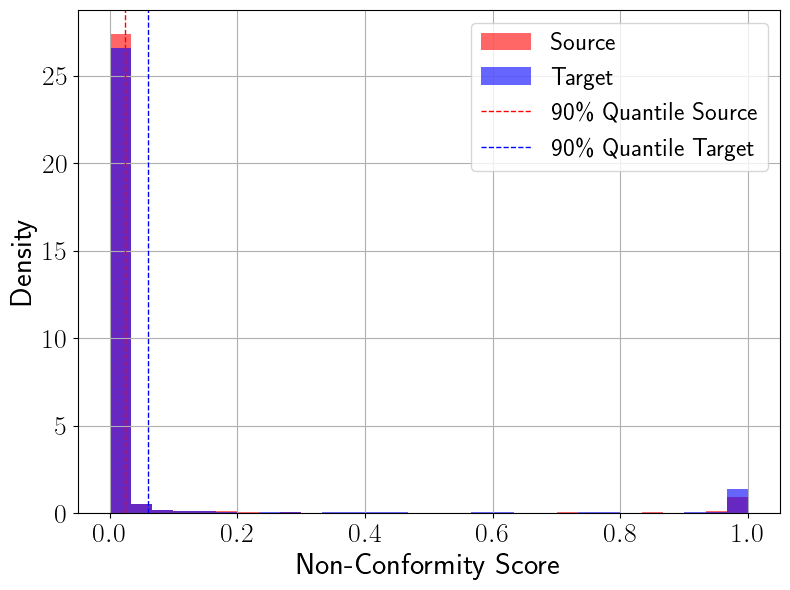

In [249]:
gamma_source = ot.sinkhorn(a_source, b_source, cost_source, reg=0.05)
gamma_target = ot.sinkhorn(a_target, b_target, cost_target, reg=0.05)


scores_cal_source = 1 - gamma_source[np.arange(len(y_cal)), y_cal]/np.sum(gamma_source, axis=1)
scores_target = 1 - gamma_target[np.arange(len(y_t)), y_t]/np.sum(gamma_target, axis=1)

plt.figure(figsize=(8, 6))

plt.hist(scores_cal_source, bins=30, color='red', alpha=0.6, density=True, label='Source')
plt.hist(scores_target, bins=30, color='blue', alpha=0.6, density=True, label='Target')
plt.axvline(x=np.quantile(scores_cal_source, 0.90), color='red', linestyle='--', label='90\% Quantile Source')
plt.axvline(x=np.quantile(scores_target, 0.90), color='blue', linestyle='--', label='90\% Quantile Target')

plt.xlabel("Non-Conformity Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()